In [ ]:
## Standard Libraries

In [2]:
%matplotlib inline

In [1]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np

## Vision stuff

In [4]:
from LogGabor import LogGabor

## Pierre's stuff

In [8]:
# TODO: passer les arguments par la ligne de commande
N_theta, N_azimuth, N_eccentricity, N_phase, N_X, N_Y, rho = 6, 12, 8, 2, 128, 128, 1.41
verbose = 1

#### Charger la matrice de certitude

In [10]:
path = "MNIST_accuracy.npy"
if os.path.isfile(path):
    accuracy =  np.load(path)
    if verbose:
        print('Loading accuracy... min, max=', accuracy.min(), accuracy.max())
else:
    print('No accuracy data found.')


Loading accuracy... min, max= 0.0145 0.9852


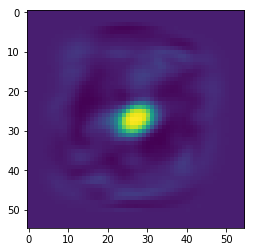

In [12]:
plt.imshow(accuracy)

### Encoding : N_theta x N_azimuth x N_eccentricity x N_phase  2D filters (to be applied on N_X x N_Y pixels)

#### Préparer l'apprentissage et les fonctions nécessaires au fonctionnement du script

In [13]:
def vectorization(N_theta=N_theta, N_azimuth=N_azimuth, N_eccentricity=N_eccentricity, N_phase=N_phase, \
                  N_X=N_X, N_Y=N_Y, rho=rho, ecc_max=.8, B_sf=.4, B_theta=np.pi/N_theta/2):
    retina = np.zeros((N_theta, N_azimuth, N_eccentricity, N_phase, N_X*N_Y))
    parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
    lg = LogGabor(parameterfile)
    lg.set_size((N_X, N_Y))
    # params = {'sf_0': .1, 'B_sf': lg.pe.B_sf,
    #           'theta': np.pi * 5 / 7., 'B_theta': lg.pe.B_theta}
    # phase = np.pi/4
    # edge = lg.normalize(lg.invert(lg.loggabor(
    #     N_X/3, 3*N_Y/4, **params)*np.exp(-1j*phase)))

    for i_theta in range(N_theta):
        for i_azimuth in range(N_azimuth):
            for i_eccentricity in range(N_eccentricity):
                ecc = ecc_max * (1/rho)**(N_eccentricity - i_eccentricity)
                r = np.sqrt(N_X**2+N_Y**2) / 2 * ecc  # radius
                sf_0 = 0.5 * 0.03 / ecc
                x = N_X/2 + r * \
                    np.cos((i_azimuth+(i_eccentricity % 2)*.5)*np.pi*2 / N_azimuth)
                y = N_Y/2 + r * \
                    np.sin((i_azimuth+(i_eccentricity % 2)*.5)*np.pi*2 / N_azimuth)
                for i_phase in range(N_phase):
                    params = {'sf_0': sf_0, 'B_sf': B_sf,
                              'theta': i_theta*np.pi/N_theta, 'B_theta': B_theta}
                    phase = i_phase * np.pi/2
                    # print(r, x, y, phase, params)

                    retina[i_theta, i_azimuth, i_eccentricity, i_phase, :] = lg.normalize(
                        lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))).ravel()


    return retina


#### Full encoding

In [15]:
retina = vectorization(N_theta, N_azimuth, N_eccentricity, N_phase, N_X, N_Y, rho)
print(retina.shape)

(6, 12, 8, 2, 16384)


In [16]:
retina_vector = retina.reshape((N_theta*N_azimuth*N_eccentricity*N_phase, N_X*N_Y))
print(retina_vector.shape)

(1152, 16384)


In [17]:
retina_inverse = np.linalg.pinv(retina_vector)
print(retina_inverse.shape)

(16384, 1152)


#### Orientation invariant power encoding (colliculus??)

In [20]:
colliculus = (retina**2).sum(axis=(0, 3))
colliculus = colliculus**.5
colliculus /= colliculus.sum(axis=-1)[:, :, None]
print(colliculus.shape)

(12, 8, 16384)


In [21]:
colliculus_vector = colliculus.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
print(colliculus_vector.shape)

(96, 16384)


In [22]:
colliculus_inverse = np.linalg.pinv(colliculus_vector)
print(colliculus_inverse.shape)

(16384, 96)


### From MNIST encoding

#### Input vectors encoding

In [55]:
def mnist_fullfield(data, i_offset, j_offset, N_pic=N_X, noise=0.,  contrast=1.):
    N_stim = data.shape[0]
    center = (N_pic-N_stim)//2

    data_fullfield = (data.min().numpy()) * np.ones((N_pic, N_pic))
    data_fullfield[int(center+i_offset):int(center+N_stim+i_offset), int(center+j_offset):int(center+N_stim+j_offset)] = data

    # data normalization
    # data_fullfield -= data_fullfield.mean()
    # data_fullfield /= data_fullfield.std()
    # data_fullfield *= std
    # data_fullfield += mean
    data_fullfield = (data_fullfield - data_fullfield.min())/(data_fullfield.max() - data_fullfield.min())
    data_fullfield *= contrast

    if noise>0.:
        data_fullfield += noise * MotionCloudNoise()

    data_retina = retina_vector @ np.ravel(data_fullfield)

    return data_retina

#### Output vectors (Accuracy/Saliency map) encoding

In [56]:
def accuracy_fullfield(accuracy, i_offset, j_offset, N_pic=N_X):
    N_stim = accuracy.shape[0]
    center = (N_pic-N_stim)//2

    accuracy_fullfield = 0.1 * np.ones((N_pic, N_pic))
    accuracy_fullfield[int(center+i_offset):int(center+N_stim+i_offset),
                 int(center+j_offset):int(center+N_stim+j_offset)] = accuracy

    accuracy_colliculus = colliculus_vector @ np.ravel(accuracy_fullfield)

    return accuracy_colliculus

#### Utilitaires

In [57]:
def couples(data, i_offset, j_offset, contrast=1.): #, device):
    #data = data.to(device)
    v = mnist_fullfield(data, i_offset, j_offset, contrast=contrast)
    a = accuracy_fullfield(accuracy, i_offset, j_offset)
    return (v, a)

In [58]:
def minmax(value, border):
    value = max(value, -border)
    value = min(value, border)
    return int(value)

In [59]:
def MotionCloudNoise(sf_0=0.125, B_sf=3.):
    mc.N_X, mc.N_Y, mc.N_frame = 128, 128, 1
    fx, fy, ft = mc.get_grids(mc.N_X, mc.N_Y, mc.N_frame)
    name = 'static'
    env = mc.envelope_gabor(fx, fy, ft, sf_0=sf_0, B_sf=B_sf, B_theta=np.inf, V_X=0., V_Y=0., B_V=0, alpha=.5)
    z = mc.rectif(mc.random_cloud(env))
    z = z.reshape((mc.N_X, mc.N_Y))

## Torch libraries

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

#### Hyperparameters

In [61]:
minibatch_size = 100  # quantity of examples that'll be processed
lr = 0.05
n_hidden1 = int(((N_theta*N_azimuth*N_eccentricity*N_phase)/4)*3)
n_hidden2 = int(((N_theta*N_azimuth*N_eccentricity*N_phase)/4))

n_hidden1 = 80
n_hidden2 = 200

print('n_hidden1', n_hidden1, ' / n_hidden2', n_hidden2)
verbose = 1
mean, std = 0.13,  .3
mean, std = 0.,  .3

n_hidden1 80  / n_hidden2 200


#### Torch stuff

In [62]:
do_cuda = False # torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if do_cuda else {}
device = torch.cuda.device("cuda" if do_cuda else "cpu")

In [63]:
#### MNIST dataset read out

In [131]:
def get_data_loader(mean=mean, std=std, batch_size=minibatch_size, train=train):
    data_loader = torch.utils.data.DataLoader(
        datasets.MNIST('/tmp/data',
                       train=train,     # def the dataset as training data
                       download=True,  # download if dataset not present on disk
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=(0,), std=(1,))])),
                       batch_size=batch_size,
                       shuffle=True, **kwargs)
    return data_loader


In [132]:
train_loader = get_data_loader(mean=mean, std=std, batch_size=minibatch_size, train = True)
test_loader = get_data_loader(mean=mean, std=std, batch_size=10000, train = False)

#### Network

In [66]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden1, n_hidden2, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)
        self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2)
        self.predict = torch.nn.Linear(n_hidden2, n_output)

    def forward(self, data, do_leaky_relu=True):
        data = F.relu(self.hidden1(data))
        data = F.relu(self.hidden2(data))
        data =  self.predict(data)
        return data


In [67]:
net = Net(n_feature=N_theta*N_azimuth*N_eccentricity*N_phase,\
          n_hidden1=n_hidden1,\
          n_hidden2=n_hidden2,\
          n_output=N_azimuth*N_eccentricity)

In [68]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [69]:
loss_func = torch.nn.BCEWithLogitsLoss()

In [70]:
#### Training

In [136]:
def train(net, minibatch_size, \
          optimizer=optimizer, \
          vsize = N_theta * N_azimuth * N_eccentricity * N_phase,\
          asize = N_azimuth * N_eccentricity, \
          offset_std=10, \
          offset_max=25, \
          verbose=1, \
          contrast=std):
    
    t_start = time.time()
    
    if verbose: print('Starting training...')
    
    for batch_idx, (data, label) in enumerate(train_loader):
        optimizer.zero_grad()

        input_ = np.zeros((minibatch_size, 1, vsize))
        a_data = np.zeros((minibatch_size, 1, asize))
        # target = np.zeros((minibatch_size, asize))

        for idx in range(minibatch_size):
            i_offset = minmax(np.random.randn() * offset_std, offset_max)
            j_offset = minmax(np.random.randn() * offset_std, offset_max)
            input_[idx, 0, :], a_data[idx, 0, :] = couples(data[idx, 0, :, :], i_offset, j_offset, contrast=contrast)

        #input_, target = Variable(torch.FloatTensor(input_)), Variable(torch.FloatTensor(a_data))
        input_, a_data = Variable(torch.FloatTensor(input_)), Variable(torch.FloatTensor(a_data))
        #input_, a_data = input_.to(device), a_data.to(device)
        #print('a_data.numpy()', a_data.numpy().shape)
        #print('... min, max=', a_data.numpy().min(), a_data.numpy().max())
        prediction = net(input_)
        #loss = loss_func(prediction, target)
        loss = loss_func(prediction, a_data)


        #input_, target = Variable(torch.FloatTensor(input_)), Variable(torch.FloatTensor(a_data))
        # input_, target = Variable(torch.FloatTensor(input_)), Variable(torch.FloatTensor(target))
        # data, target = data.to(self.device), target.to(self.device)

        # prediction = net(input_)
        # loss = loss_func(prediction, target)

        loss.backward()
        optimizer.step()

        if verbose and batch_idx % 10 == 0:
            print('[{}/{}] Loss: {} Time: {:.2f} mn'.format(
                batch_idx*minibatch_size, len(data_loader.dataset),
                loss.data.numpy(), (time.time()-t_start)/60))
    return net


In [137]:
def test(net, minibatch_size, optimizer=optimizer,
         vsize=N_theta*N_azimuth*N_eccentricity*N_phase,
         asize=N_azimuth*N_eccentricity, offset_std=10, offset_max=25):
    #for batch_idx, (data, label) in enumerate(test_loader):
    data, label = next(iter(test_loader))
    
    input_, a_data = np.zeros((minibatch_size, 1, vsize)), np.zeros(
        (minibatch_size, 1, asize))
    target = np.zeros((minibatch_size, asize))
    for idx in range(minibatch_size):
        i_offset, j_offset = minmax(np.random.randn()*offset_std, offset_max), minmax(np.random.randn()*offset_std, offset_max)
        input_[idx, 0, :], a_data[idx, 0, :] = couples(data[idx, 0, :], i_offset, j_offset)
        target[idx, :] = a_data[idx, 0, :]

    input_ = Variable(torch.FloatTensor(input_))
    target = Variable(torch.FloatTensor(a_data))

    prediction = net(input_)
    loss = loss_func(prediction, target)

    return loss.data.numpy()


In [138]:
for epoch in range(1, 100):
    train(net, minibatch_size)
    Accuracy = test(net, minibatch_size)
    print('Test set: Final Accuracy: {:.3f}%'.format(Accuracy*100)) # print que le pourcentage de réussite final

Starting training...
[0/60000] Loss: 0.36658450961112976 Time: 0.03 mn
[1000/60000] Loss: 0.36276131868362427 Time: 0.27 mn
[2000/60000] Loss: 0.36529436707496643 Time: 0.52 mn
[3000/60000] Loss: 0.36192014813423157 Time: 0.77 mn
[4000/60000] Loss: 0.36124202609062195 Time: 1.00 mn
[5000/60000] Loss: 0.36096009612083435 Time: 1.24 mn
[6000/60000] Loss: 0.3611468970775604 Time: 1.49 mn
[7000/60000] Loss: 0.3601160943508148 Time: 1.75 mn
[8000/60000] Loss: 0.3630506992340088 Time: 2.02 mn
[9000/60000] Loss: 0.3626285493373871 Time: 2.27 mn
[10000/60000] Loss: 0.3617857098579407 Time: 2.51 mn
[11000/60000] Loss: 0.3614838719367981 Time: 2.75 mn
[12000/60000] Loss: 0.36246809363365173 Time: 2.99 mn
[13000/60000] Loss: 0.36034858226776123 Time: 3.24 mn
[14000/60000] Loss: 0.3664385974407196 Time: 3.50 mn
[15000/60000] Loss: 0.3632458448410034 Time: 3.77 mn
[16000/60000] Loss: 0.36428752541542053 Time: 4.02 mn
[17000/60000] Loss: 0.3589889109134674 Time: 4.28 mn
[18000/60000] Loss: 0.3598297

[31000/60000] Loss: 0.3693650960922241 Time: 7.81 mn
[32000/60000] Loss: 0.37628239393234253 Time: 8.06 mn
[33000/60000] Loss: 0.3668074309825897 Time: 8.34 mn
[34000/60000] Loss: 0.3691941499710083 Time: 8.58 mn
[35000/60000] Loss: 0.36977458000183105 Time: 8.81 mn
[36000/60000] Loss: 0.37408173084259033 Time: 9.06 mn
[37000/60000] Loss: 0.37420201301574707 Time: 9.34 mn
[38000/60000] Loss: 0.3722103238105774 Time: 9.62 mn
[39000/60000] Loss: 0.3744988739490509 Time: 9.89 mn
[40000/60000] Loss: 0.37387093901634216 Time: 10.14 mn
[41000/60000] Loss: 0.37085166573524475 Time: 10.36 mn
[42000/60000] Loss: 0.3678610622882843 Time: 10.59 mn
[43000/60000] Loss: 0.37357112765312195 Time: 10.80 mn
[44000/60000] Loss: 0.3680294454097748 Time: 11.04 mn
[45000/60000] Loss: 0.36964935064315796 Time: 11.31 mn
[46000/60000] Loss: 0.3732318878173828 Time: 11.57 mn
[47000/60000] Loss: 0.3727816939353943 Time: 11.83 mn
[48000/60000] Loss: 0.36618199944496155 Time: 12.07 mn
[49000/60000] Loss: 0.370580

[1000/60000] Loss: 0.36803239583969116 Time: 0.27 mn
[2000/60000] Loss: 0.3697509169578552 Time: 0.53 mn
[3000/60000] Loss: 0.366252601146698 Time: 0.80 mn
[4000/60000] Loss: 0.3694571554660797 Time: 1.06 mn
[5000/60000] Loss: 0.36764222383499146 Time: 1.30 mn
[6000/60000] Loss: 0.3748120665550232 Time: 1.56 mn
[7000/60000] Loss: 0.36800187826156616 Time: 1.80 mn
[8000/60000] Loss: 0.3711881935596466 Time: 2.04 mn
[9000/60000] Loss: 0.3726336658000946 Time: 2.31 mn
[10000/60000] Loss: 0.3709114193916321 Time: 2.57 mn
[11000/60000] Loss: 0.36873412132263184 Time: 2.82 mn
[12000/60000] Loss: 0.37077590823173523 Time: 3.07 mn
[13000/60000] Loss: 0.3707696795463562 Time: 3.30 mn
[14000/60000] Loss: 0.3683398365974426 Time: 3.56 mn
[15000/60000] Loss: 0.3725301921367645 Time: 3.82 mn
[16000/60000] Loss: 0.3680834174156189 Time: 4.09 mn
[17000/60000] Loss: 0.37286877632141113 Time: 4.34 mn
[18000/60000] Loss: 0.3701728284358978 Time: 4.60 mn
[19000/60000] Loss: 0.371897429227829 Time: 4.86 m

[33000/60000] Loss: 0.37004008889198303 Time: 8.45 mn
[34000/60000] Loss: 0.3657638132572174 Time: 8.70 mn
[35000/60000] Loss: 0.366225004196167 Time: 8.93 mn
[36000/60000] Loss: 0.3688717782497406 Time: 9.18 mn
[37000/60000] Loss: 0.3691257834434509 Time: 9.44 mn
[38000/60000] Loss: 0.3695734441280365 Time: 9.72 mn
[39000/60000] Loss: 0.372018426656723 Time: 9.98 mn
[40000/60000] Loss: 0.368853896856308 Time: 10.25 mn
[41000/60000] Loss: 0.371701717376709 Time: 10.49 mn
[42000/60000] Loss: 0.3630617558956146 Time: 10.73 mn
[43000/60000] Loss: 0.36930975317955017 Time: 10.98 mn
[44000/60000] Loss: 0.3672700822353363 Time: 11.23 mn
[45000/60000] Loss: 0.3679490387439728 Time: 11.48 mn
[46000/60000] Loss: 0.3659203350543976 Time: 11.73 mn
[47000/60000] Loss: 0.3689552843570709 Time: 11.99 mn
[48000/60000] Loss: 0.36989495158195496 Time: 12.23 mn
[49000/60000] Loss: 0.3731318414211273 Time: 12.49 mn
[50000/60000] Loss: 0.36709123849868774 Time: 12.75 mn
[51000/60000] Loss: 0.3681772351264

[4000/60000] Loss: 0.3705199658870697 Time: 1.04 mn
[5000/60000] Loss: 0.36997470259666443 Time: 1.27 mn
[6000/60000] Loss: 0.36624738574028015 Time: 1.50 mn
[7000/60000] Loss: 0.368581622838974 Time: 1.74 mn
[8000/60000] Loss: 0.36795178055763245 Time: 2.04 mn
[9000/60000] Loss: 0.3690657615661621 Time: 2.29 mn
[10000/60000] Loss: 0.36861690878868103 Time: 2.53 mn
[11000/60000] Loss: 0.37229883670806885 Time: 2.78 mn
[12000/60000] Loss: 0.3717990219593048 Time: 3.01 mn
[13000/60000] Loss: 0.36751729249954224 Time: 3.29 mn
[14000/60000] Loss: 0.3714536726474762 Time: 3.56 mn
[15000/60000] Loss: 0.37099143862724304 Time: 3.81 mn
[16000/60000] Loss: 0.36222153902053833 Time: 4.07 mn
[17000/60000] Loss: 0.372050404548645 Time: 4.29 mn
[18000/60000] Loss: 0.3667837977409363 Time: 4.54 mn
[19000/60000] Loss: 0.3659960925579071 Time: 4.80 mn
[20000/60000] Loss: 0.3710232377052307 Time: 5.07 mn
[21000/60000] Loss: 0.36449742317199707 Time: 5.32 mn
[22000/60000] Loss: 0.3696151077747345 Time: 

[36000/60000] Loss: 0.36982712149620056 Time: 9.24 mn
[37000/60000] Loss: 0.3742036521434784 Time: 9.53 mn
[38000/60000] Loss: 0.3714326322078705 Time: 9.80 mn
[39000/60000] Loss: 0.37064963579177856 Time: 10.07 mn
[40000/60000] Loss: 0.363525927066803 Time: 10.36 mn
[41000/60000] Loss: 0.3666954040527344 Time: 10.64 mn
[42000/60000] Loss: 0.3660580813884735 Time: 10.92 mn
[43000/60000] Loss: 0.36753445863723755 Time: 11.16 mn
[44000/60000] Loss: 0.3686612844467163 Time: 11.41 mn
[45000/60000] Loss: 0.3719816207885742 Time: 11.66 mn
[46000/60000] Loss: 0.36870503425598145 Time: 11.91 mn
[47000/60000] Loss: 0.37000465393066406 Time: 12.16 mn
[48000/60000] Loss: 0.3688969016075134 Time: 12.41 mn
[49000/60000] Loss: 0.3687393367290497 Time: 12.63 mn
[50000/60000] Loss: 0.3730863332748413 Time: 12.89 mn
[51000/60000] Loss: 0.3671116530895233 Time: 13.18 mn
[52000/60000] Loss: 0.36721688508987427 Time: 13.46 mn
[53000/60000] Loss: 0.3665006160736084 Time: 13.74 mn
[54000/60000] Loss: 0.3721

[7000/60000] Loss: 0.37420862913131714 Time: 1.77 mn
[8000/60000] Loss: 0.3648318946361542 Time: 2.02 mn
[9000/60000] Loss: 0.37100720405578613 Time: 2.28 mn
[10000/60000] Loss: 0.3645310401916504 Time: 2.52 mn
[11000/60000] Loss: 0.36797642707824707 Time: 2.77 mn
[12000/60000] Loss: 0.3711870014667511 Time: 3.02 mn
[13000/60000] Loss: 0.36728283762931824 Time: 3.26 mn
[14000/60000] Loss: 0.37375420331954956 Time: 3.51 mn
[15000/60000] Loss: 0.37216150760650635 Time: 3.75 mn
[16000/60000] Loss: 0.37010130286216736 Time: 4.00 mn
[17000/60000] Loss: 0.3698771297931671 Time: 4.24 mn
[18000/60000] Loss: 0.37032702565193176 Time: 4.48 mn
[19000/60000] Loss: 0.3709165155887604 Time: 4.73 mn
[20000/60000] Loss: 0.3663666248321533 Time: 4.97 mn
[21000/60000] Loss: 0.3708939254283905 Time: 5.22 mn
[22000/60000] Loss: 0.36995333433151245 Time: 5.47 mn
[23000/60000] Loss: 0.3692893385887146 Time: 5.72 mn
[24000/60000] Loss: 0.36818498373031616 Time: 5.95 mn
[25000/60000] Loss: 0.3687629699707031 

[39000/60000] Loss: 0.3709069490432739 Time: 9.55 mn
[40000/60000] Loss: 0.37544262409210205 Time: 9.84 mn
[41000/60000] Loss: 0.37162065505981445 Time: 10.08 mn
[42000/60000] Loss: 0.37060877680778503 Time: 10.32 mn
[43000/60000] Loss: 0.3695639371871948 Time: 10.57 mn
[44000/60000] Loss: 0.37594056129455566 Time: 10.84 mn
[45000/60000] Loss: 0.36853331327438354 Time: 11.12 mn
[46000/60000] Loss: 0.3725660443305969 Time: 11.37 mn
[47000/60000] Loss: 0.37004324793815613 Time: 11.61 mn
[48000/60000] Loss: 0.37141531705856323 Time: 11.86 mn
[49000/60000] Loss: 0.3746981918811798 Time: 12.12 mn
[50000/60000] Loss: 0.3735254108905792 Time: 12.40 mn
[51000/60000] Loss: 0.36415666341781616 Time: 12.66 mn
[52000/60000] Loss: 0.3708875775337219 Time: 12.90 mn
[53000/60000] Loss: 0.3689098656177521 Time: 13.15 mn
[54000/60000] Loss: 0.3735654950141907 Time: 13.40 mn
[55000/60000] Loss: 0.3733198344707489 Time: 13.68 mn
[56000/60000] Loss: 0.3700028657913208 Time: 13.92 mn
[57000/60000] Loss: 0.

[10000/60000] Loss: 0.3726930022239685 Time: 2.52 mn
[11000/60000] Loss: 0.37069299817085266 Time: 2.76 mn
[12000/60000] Loss: 0.3709539771080017 Time: 2.98 mn
[13000/60000] Loss: 0.37554478645324707 Time: 3.21 mn
[14000/60000] Loss: 0.37055885791778564 Time: 3.47 mn
[15000/60000] Loss: 0.37326109409332275 Time: 3.74 mn
[16000/60000] Loss: 0.3730524778366089 Time: 3.97 mn
[17000/60000] Loss: 0.3680020868778229 Time: 4.19 mn
[18000/60000] Loss: 0.3731994330883026 Time: 4.43 mn
[19000/60000] Loss: 0.3700224459171295 Time: 4.66 mn
[20000/60000] Loss: 0.36901354789733887 Time: 4.91 mn
[21000/60000] Loss: 0.3704725503921509 Time: 5.17 mn
[22000/60000] Loss: 0.37024039030075073 Time: 5.42 mn
[23000/60000] Loss: 0.37651902437210083 Time: 5.66 mn
[24000/60000] Loss: 0.3692821264266968 Time: 5.91 mn
[25000/60000] Loss: 0.3800848424434662 Time: 6.16 mn
[26000/60000] Loss: 0.36561843752861023 Time: 6.39 mn
[27000/60000] Loss: 0.37190449237823486 Time: 6.63 mn
[28000/60000] Loss: 0.370259255170822

[42000/60000] Loss: 0.37031853199005127 Time: 10.40 mn
[43000/60000] Loss: 0.37616127729415894 Time: 10.64 mn
[44000/60000] Loss: 0.36943885684013367 Time: 10.87 mn
[45000/60000] Loss: 0.37024176120758057 Time: 11.10 mn
[46000/60000] Loss: 0.37344104051589966 Time: 11.35 mn
[47000/60000] Loss: 0.37292733788490295 Time: 11.61 mn
[48000/60000] Loss: 0.37167492508888245 Time: 11.86 mn
[49000/60000] Loss: 0.37480658292770386 Time: 12.12 mn
[50000/60000] Loss: 0.37309256196022034 Time: 12.36 mn
[51000/60000] Loss: 0.3704323172569275 Time: 12.59 mn
[52000/60000] Loss: 0.3730982542037964 Time: 12.83 mn
[53000/60000] Loss: 0.3728838264942169 Time: 13.06 mn
[54000/60000] Loss: 0.37781548500061035 Time: 13.33 mn
[55000/60000] Loss: 0.3710165023803711 Time: 13.57 mn
[56000/60000] Loss: 0.37185150384902954 Time: 13.83 mn
[57000/60000] Loss: 0.3722531497478485 Time: 14.10 mn
[58000/60000] Loss: 0.37634679675102234 Time: 14.37 mn
[59000/60000] Loss: 0.37407130002975464 Time: 14.62 mn
Test set: Final

[13000/60000] Loss: 0.37123793363571167 Time: 3.24 mn
[14000/60000] Loss: 0.37486690282821655 Time: 3.48 mn
[15000/60000] Loss: 0.37539002299308777 Time: 3.71 mn
[16000/60000] Loss: 0.37424877285957336 Time: 3.97 mn
[17000/60000] Loss: 0.3699190318584442 Time: 4.19 mn
[18000/60000] Loss: 0.3699331283569336 Time: 4.46 mn
[19000/60000] Loss: 0.3737849295139313 Time: 4.72 mn
[20000/60000] Loss: 0.37211090326309204 Time: 4.99 mn
[21000/60000] Loss: 0.3741242289543152 Time: 5.24 mn
[22000/60000] Loss: 0.3720620274543762 Time: 5.48 mn
[23000/60000] Loss: 0.37575092911720276 Time: 5.72 mn
[24000/60000] Loss: 0.37376803159713745 Time: 5.97 mn
[25000/60000] Loss: 0.37077081203460693 Time: 6.21 mn
[26000/60000] Loss: 0.3724323511123657 Time: 6.47 mn
[27000/60000] Loss: 0.3714081048965454 Time: 6.72 mn
[28000/60000] Loss: 0.37033727765083313 Time: 6.99 mn
[29000/60000] Loss: 0.37623271346092224 Time: 7.24 mn
[30000/60000] Loss: 0.3724152445793152 Time: 7.49 mn
[31000/60000] Loss: 0.36737254261970

[45000/60000] Loss: 0.36979782581329346 Time: 11.10 mn
[46000/60000] Loss: 0.374904602766037 Time: 11.35 mn
[47000/60000] Loss: 0.3761039972305298 Time: 11.62 mn
[48000/60000] Loss: 0.37136930227279663 Time: 11.87 mn
[49000/60000] Loss: 0.37406453490257263 Time: 12.12 mn
[50000/60000] Loss: 0.37608104944229126 Time: 12.35 mn
[51000/60000] Loss: 0.37449902296066284 Time: 12.58 mn
[52000/60000] Loss: 0.3733029067516327 Time: 12.82 mn
[53000/60000] Loss: 0.37651243805885315 Time: 13.09 mn
[54000/60000] Loss: 0.37499818205833435 Time: 13.36 mn
[55000/60000] Loss: 0.37436285614967346 Time: 13.60 mn
[56000/60000] Loss: 0.3766932487487793 Time: 13.84 mn
[57000/60000] Loss: 0.37078678607940674 Time: 14.07 mn
[58000/60000] Loss: 0.37550488114356995 Time: 14.30 mn
[59000/60000] Loss: 0.3702729642391205 Time: 14.57 mn
Test set: Final Accuracy: 37.173%
Starting training...
[0/60000] Loss: 0.36800989508628845 Time: 0.02 mn
[1000/60000] Loss: 0.374388188123703 Time: 0.27 mn
[2000/60000] Loss: 0.3747

[16000/60000] Loss: 0.37355002760887146 Time: 3.98 mn
[17000/60000] Loss: 0.37256935238838196 Time: 4.25 mn
[18000/60000] Loss: 0.3718133866786957 Time: 4.51 mn
[19000/60000] Loss: 0.370567262172699 Time: 4.75 mn
[20000/60000] Loss: 0.37244901061058044 Time: 4.97 mn
[21000/60000] Loss: 0.37647709250450134 Time: 5.20 mn
[22000/60000] Loss: 0.37267783284187317 Time: 5.42 mn
[23000/60000] Loss: 0.37182337045669556 Time: 5.68 mn
[24000/60000] Loss: 0.3687748908996582 Time: 5.93 mn
[25000/60000] Loss: 0.3720420002937317 Time: 6.20 mn
[26000/60000] Loss: 0.37577158212661743 Time: 6.46 mn
[27000/60000] Loss: 0.3754437565803528 Time: 6.72 mn
[28000/60000] Loss: 0.3696758449077606 Time: 6.98 mn
[29000/60000] Loss: 0.3724939227104187 Time: 7.25 mn
[30000/60000] Loss: 0.36961841583251953 Time: 7.48 mn
[31000/60000] Loss: 0.37236088514328003 Time: 7.70 mn
[32000/60000] Loss: 0.37359973788261414 Time: 7.94 mn
[33000/60000] Loss: 0.364663690328598 Time: 8.22 mn
[34000/60000] Loss: 0.3742117881774902

KeyboardInterrupt: 

In [139]:
vsize = N_theta * N_azimuth * N_eccentricity * N_phase
asize = N_azimuth * N_eccentricity
offset_std=10
offset_max=25

data, label = next(iter(test_loader))
input_ = np.zeros((minibatch_size, 1, vsize))
a_data = np.zeros((minibatch_size, 1, asize))
        # target = np.zeros((minibatch_size, asize))

for idx in range(minibatch_size):
    i_offset = minmax(np.random.randn() * offset_std, offset_max)
    j_offset = minmax(np.random.randn() * offset_std, offset_max)
    input_[idx, 0, :], a_data[idx, 0, :] = couples(data[idx, 0, :, :], i_offset, j_offset, contrast=std)

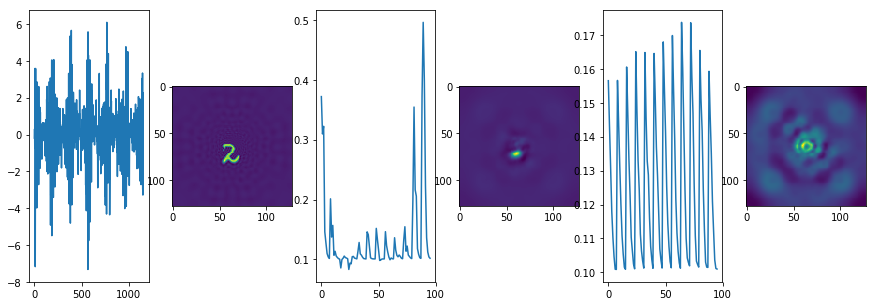

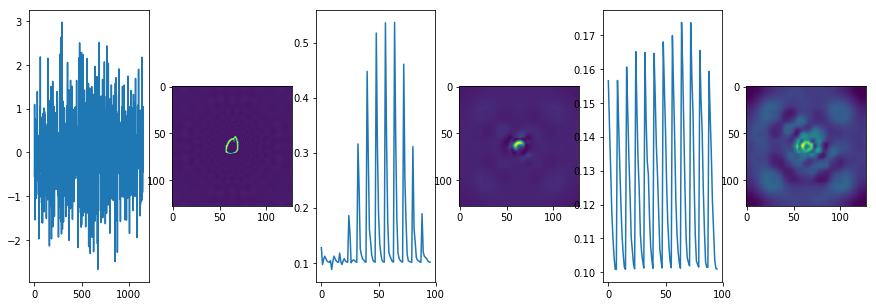

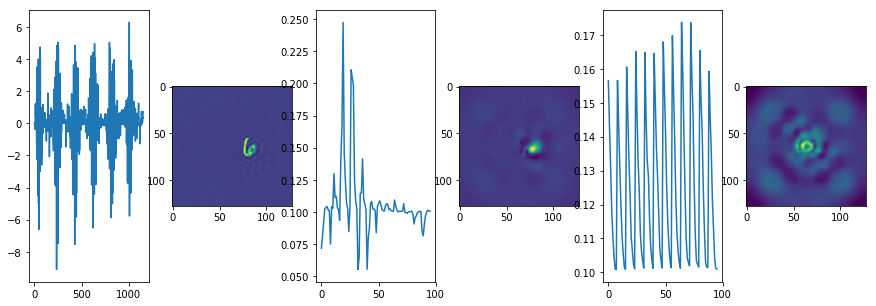

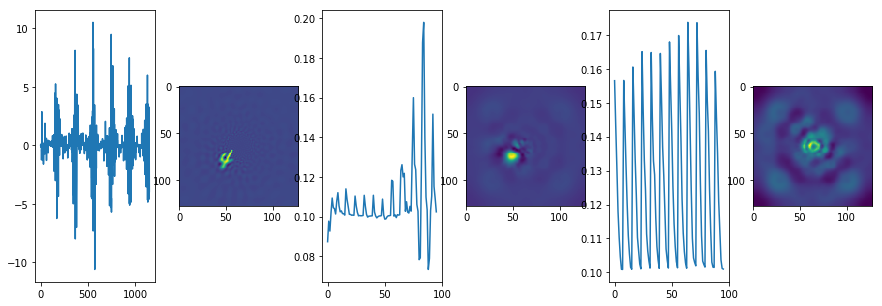

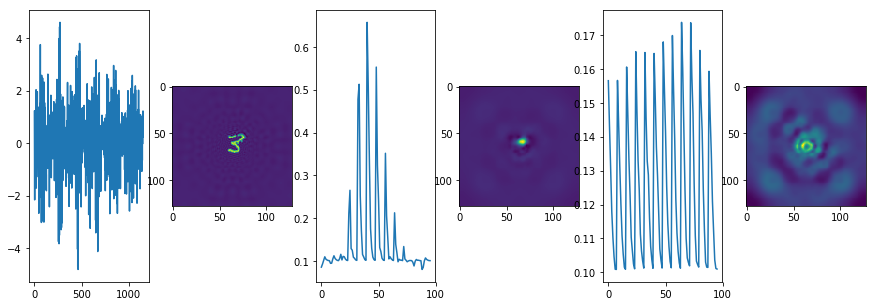

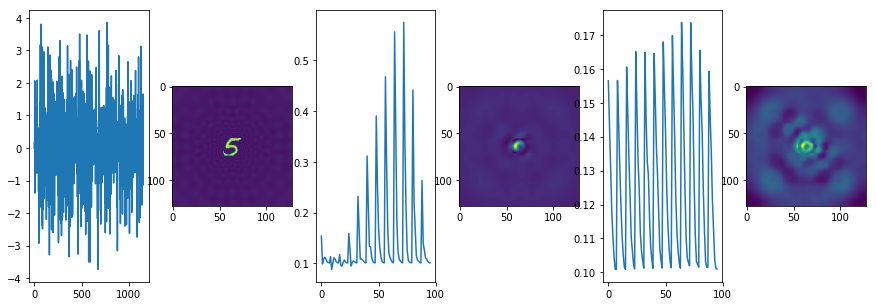

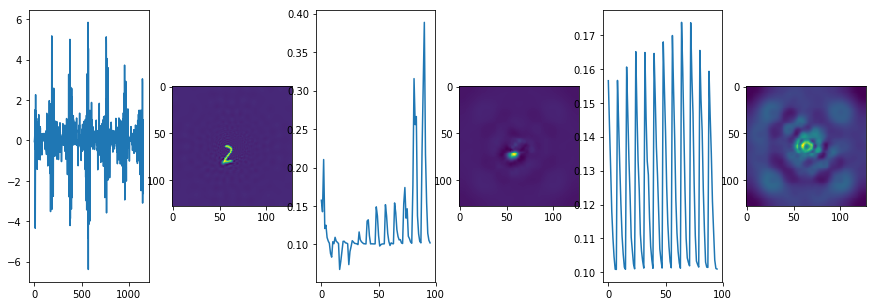

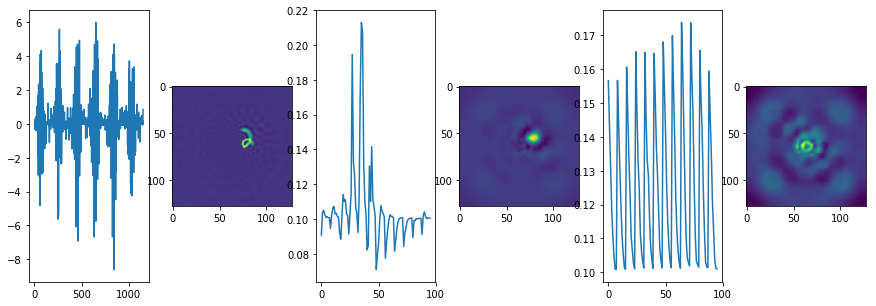

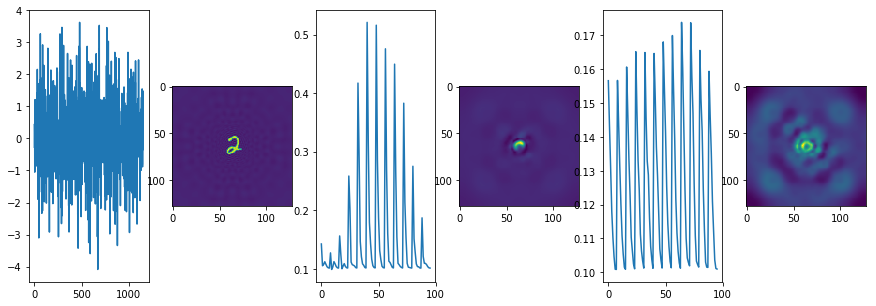

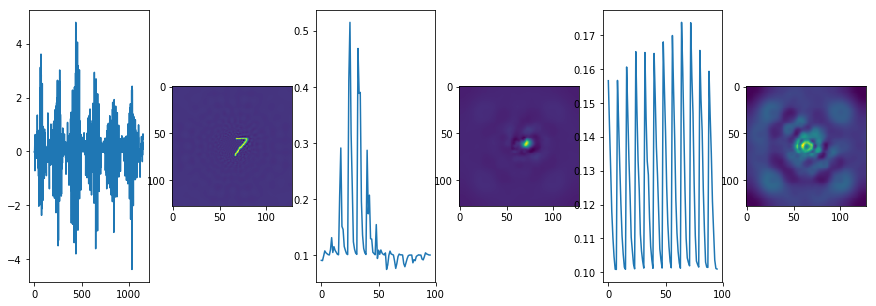

In [140]:
for _ in range(10):
    im = retina_inverse @ input_[_,0,:]
    plt.figure(figsize = (15, 5))
    plt.subplot(161)
    plt.plot(input_[_,0,:])
    plt.subplot(162)
    plt.imshow(im.reshape(128, 128))
    plt.subplot(163)
    plt.plot(a_data[_,0,:])    
    col = colliculus_inverse @ a_data[_,0,:]
    plt.subplot(164)
    plt.imshow(col.reshape(128, 128))
    in_ = Variable(torch.FloatTensor(input_[_,0,:]))
    out = net(in_)
    plt.subplot(165)
    out_sig = F.sigmoid(out).detach().numpy()
    plt.plot(out_sig)    
    view = colliculus_inverse @ out_sig
    plt.subplot(166)
    plt.imshow(view.reshape(128, 128))
                                 